## Trigger Word Detection

We will construct a speech dataset and implement an algorithm for trigger word detection (sometimes also called keyword detection, or wake word detection. Trigger word detection is the technology that allows devices like Amazon Alexa, Google Home, Apple Siri, and Baidu DuerOS to wake up upon hearing a certain word.

For this notebook, our trigger word will be "activate". Every time it hears "activate", it will make a "chiming" sound. 


<a name='0'></a>
## Packages

In [1]:
import numpy as np
from pydub import AudioSegment
import IPython

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

from utils.nmt_utils.td_utils import *

d:\Code\Data Science\Projects\Machine Learning by hand\Deep-Learning\.venv\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Data synthesis: Creating a Speech Dataset 

Let's build a dataset for our trigger word detection algorithm. 
* A speech dataset should ideally be as close as possible to the application we will want to run it on. 
* In this case, we'd like to detect the word "activate" in working environments (library, home, offices, open-spaces ...). 
* Therefore, we need to create recordings with a mix of positive words ("activate") and negative words (random words other than activate) on different background sounds.

### Listening to the Data   

* In the __data_path__ below, we can find a subset of the raw audio files of the positive words, negative words, and background noise. We will use these audio files to synthesize a dataset to train the model. 
    * The "activate" directory contains positive examples of people saying the word "activate". 
    * The "negatives" directory contains negative examples of people saying random words other than "activate". 
    * There is one word per audio recording. 
    * The "backgrounds" directory contains 10 second clips of background noise in different environments.

In [2]:
data_path = "../datasets/audio"

In [3]:
IPython.display.Audio(f"{data_path}/activates/1.wav")

In [4]:
IPython.display.Audio(f"{data_path}/negatives/4.wav")

In [5]:
IPython.display.Audio(f"{data_path}/backgrounds/1.wav")

We will use these three types of recordings (positives/negatives/backgrounds) to create a labeled dataset.

### From Audio Recordings to Spectrograms

We can think of an audio recording as a long list of numbers measuring the little air pressure changes detected by the microphone. 
We will use audio sampled at 44100 Hz (or 44100 Hertz). 
    * This means the microphone gives us 44,100 numbers per second. 
    * Thus, a 10 second audio clip is represented by 441,000 numbers (= $10 \times 44,100$). 

#### Spectrogram
* It is quite difficult to figure out from this "raw" representation of audio whether the word "activate" was said. 
* In order to help our sequence model more easily learn to detect trigger words, we will compute a *spectrogram* of the audio. 
* The spectrogram tells us how much different frequencies are present in an audio clip at any moment in time. 
* A spectrogram is computed by sliding a window over the raw audio signal, and calculating the most active frequencies in each window using a Fourier transform. 

In [6]:
IPython.display.Audio(f"{data_path}/audio_examples/example_train.wav")

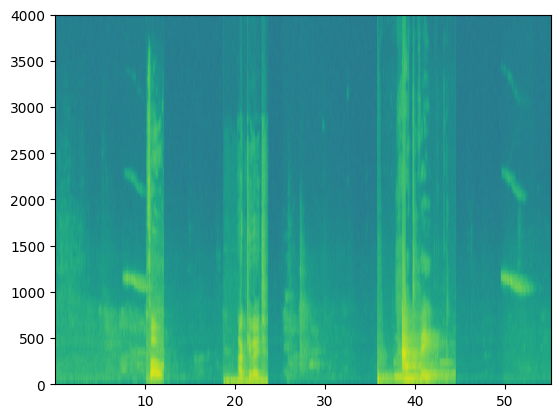

In [7]:
x = graph_spectrogram(f"{data_path}/audio_examples/example_train.wav")

The graph above represents how active each frequency is (y axis) over a number of time-steps (x axis). 

<center><img src="images/spectrogram.png" style="width:500px;height:200px;"></center>
<center> **Figure 1**: Spectrogram of an audio recording </center>


* The color in the spectrogram shows the degree to which different frequencies are present (loud) in the audio at different points in time. 
* Green means a certain frequency is more active or more present in the audio clip (louder).
* Blue squares denote less active frequencies.
* The dimension of the output spectrogram depends upon the hyperparameters of the spectrogram software and the length of the input. 
* In this notebook, we will be working with 10 second audio clips as the "standard length" for our training examples. 
    * The number of timesteps of the spectrogram will be 5511. 
    * We'll see later that the spectrogram will be the input $x$ into the network, and so $T_x = 5511$.

In [8]:
_, data = wavfile.read(f"{data_path}/audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


Now, we can define:

In [9]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

#### Dividing into time-intervals
Note that we may divide a 10 second interval of time with different units (steps).
* Raw audio divides 10 seconds into 441,000 units.
* A spectrogram divides 10 seconds into 5,511 units.
    * $T_x = 5511$
* We will use a Python module `pydub` to synthesize audio, and it divides 10 seconds into 10,000 units.
* The output of our model will divide 10 seconds into 1,375 units.
    * $T_y = 1375$
    * For each of the 1375 time steps, the model predicts whether someone recently finished saying the trigger word "activate". 
* All of these are hyperparameters and can be changed (except the 441000, which is a function of the microphone). 
* We have chosen values that are within the standard range used for speech systems.

In [10]:
Ty = 1375 # The number of time steps in the output of our model

## Generating a Single Training Example

#### Benefits of synthesizing data
Because speech data is hard to acquire and label, we will synthesize our training data using the audio clips of activates, negatives, and backgrounds. It is quite slow to record lots of 10 second audio clips with random "activates" in it. Instead, it is easier to record lots of positives and negative words, and record background noise separately (or download background noise from free online sources). 

#### Process for Synthesizing an audio clip
* To synthesize a single training example, we will:
    - Pick a random 10 second background audio clip
    - Randomly insert 0-4 audio clips of "activate" into this 10 sec. clip
    - Randomly insert 0-2 audio clips of negative words into this 10 sec. clip
* Because we had synthesized the word "activate" into the background clip, we know exactly when in the 10 second clip the "activate" makes its appearance. 
    * We'll see later that this makes it easier to generate the labels $y^{\langle t \rangle}$ as well. 

#### Pydub
* We will use the pydub package to manipulate audio. 
* Pydub converts raw audio files into lists of Pydub data structures.
* Pydub uses 1ms as the discretization interval (1 ms is 1 millisecond = 1/1000 seconds).
    * This is why a 10 second clip is always represented using 10,000 steps. 

In [11]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio(f'{data_path}/')

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
721 

activate[1] len: different `activate` clips can have different lengths
731 



#### Overlaying positive/negative 'word' audio clips on top of the background audio

* Given a 10 second background clip and a short audio clip containing a positive or negative word, we need to be able to "add" the word audio clip on top of the background audio.
* We will be inserting multiple clips of positive/negative words into the background, and we don't want to insert an "activate" or a random word somewhere that overlaps with another clip we had previously added. 
    * To ensure that the 'word' audio segments do not overlap when inserted, we will keep track of the times of previously inserted audio clips. 
* To be clear, when we insert a 1 second "activate" onto a 10 second clip of cafe noise, **we do not end up with an 11 sec clip.** 
    * The resulting audio clip is still 10 seconds long.
    * We'll see later how pydub allows we to do this. 

#### Label the positive/negative words
* Recall that the labels $y^{\langle t \rangle}$ represent whether or not someone has just finished saying "activate". 
    * $y^{\langle t \rangle} = 1$ when that clip has finished saying "activate".
    * Given a background clip, we can initialize $y^{\langle t \rangle}=0$ for all $t$, since the clip doesn't contain any "activate". 
* When we insert or overlay an "activate" clip, we will also update labels for $y^{\langle t \rangle}$.
    * Rather than updating the label of a single time step, we will update 50 steps of the output to have target label 1. 
    * Recall from the lecture on trigger word detection that updating several consecutive time steps can make the training data more balanced.
* We will train a GRU (Gated Recurrent Unit) to detect when someone has **finished** saying "activate". 

##### Example
* Suppose the synthesized "activate" clip ends at the 5 second mark in the 10 second audio - exactly halfway into the clip. 
* Recall that $T_y = 1375$, so timestep $687 = $ `int(1375*0.5)` corresponds to the moment 5 seconds into the audio clip. 
* Set $y^{\langle 688 \rangle} = 1$. 
* We will allow the GRU to detect "activate" anywhere within a short time-internal **after** this moment, so we actually **set 50 consecutive values** of the label $y^{\langle t \rangle}$ to 1. 
    * Specifically, we have $y^{\langle 688 \rangle} = y^{\langle 689 \rangle} = \cdots = y^{\langle 737 \rangle} = 1$.  

##### Synthesized data is easier to label
* This is another reason for synthesizing the training data: It's relatively straightforward to generate these labels $y^{\langle t \rangle}$ as described above. 
* In contrast, if we have 10sec of audio recorded on a microphone, it's quite time consuming for a person to listen to it and mark manually exactly when "activate" finished. 

#### Visualizing the labels
* Here's a figure illustrating the labels $y^{\langle t \rangle}$ in a clip.
    * We have inserted "activate", "innocent", "activate", "baby." 
    * Note that the positive labels "1" are associated only with the positive words. 

<center><img src="images/label_diagram.png" style="width:500px;height:200px;"></center>
<center> **Figure 2** </center>



### Helper functions

#### Get a random time segment

The function `get_random_time_segment(segment_ms)` returns a random time segment onto which we can insert an audio clip of duration `segment_ms`. 

In [12]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)